In [1]:
import cv2
import numpy as np
import os
import joblib
import random
import time
import mahotas  # Para calcular momentos de Zernike
from matplotlib import pyplot as plt


In [2]:
def aplicar_clahe(imagen_gris, clipLimit=2.0, tileGridSize=(8,8)):
    """
    Aplica CLAHE para mejorar el contraste local.
    """
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    return clahe.apply(imagen_gris)

def ajustar_gamma(img, gamma=1.0):
    """
    Aplica corrección gamma usando una LUT.
    """
    invGamma = 1.0 / gamma
    tabla = np.array([((i / 255.0) ** invGamma) * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(img, tabla)

def segmentar_mano(imagen_gris):
    """
    Realiza la segmentación de la mano:
    1. Aplica un suavizado (Gaussian Blur).
    2. Detecta bordes con Canny.
    3. Filtra bordes mediante operaciones morfológicas.
    4. Encuentra el contorno mayor y genera una máscara.
    """
    # Suavizado para reducir el ruido
    imagen_blur = cv2.GaussianBlur(imagen_gris, (5,5), 0)
    # Detector de bordes Canny
    bordes = cv2.Canny(imagen_blur, threshold1=50, threshold2=120)
    
    # Morfología: Cierre para unir bordes
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    bordes_filtrados = cv2.morphologyEx(bordes, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    # Encontrar contornos y seleccionar el de mayor área
    contornos, _ = cv2.findContours(bordes_filtrados, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contornos:
        return None, None  # No se encontró contorno
    contorno_mano = max(contornos, key=cv2.contourArea)
    
    # Crear máscara rellenando el contorno mayor
    mascara = np.zeros_like(imagen_gris)
    cv2.drawContours(mascara, [contorno_mano], -1, color=255, thickness=cv2.FILLED)
    
    # Refinar la máscara: apertura para quitar ruido, cierre para unir huecos
    mascara = cv2.morphologyEx(mascara, cv2.MORPH_OPEN, kernel, iterations=1)
    mascara = cv2.morphologyEx(mascara, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    return mascara, contorno_mano

def preprocesar_imagen(imagen, gamma=1.2):
    """
    Preprocesa la imagen:
    1. Conversión a escala de grises.
    2. Aplicación de CLAHE.
    3. Corrección Gamma.
    4. Segmentación de la mano.
    Retorna:
        - imagen_corr: imagen en gris corregida.
        - mascara: máscara binaria de la mano.
        - contorno_mano: contorno mayor encontrado.
    """
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    imagen_clahe = aplicar_clahe(gris)
    imagen_corr = ajustar_gamma(imagen_clahe, gamma=gamma)
    mascara, contorno_mano = segmentar_mano(imagen_corr)
    return imagen_corr, mascara, contorno_mano


In [3]:
def calcular_hu_moments(mascara):
    """
    Calcula los Hu Moments a partir de la máscara binaria.
    """
    M = cv2.moments(mascara)
    hu = cv2.HuMoments(M).flatten()
    # Aplicar log-transform para mejor dispersión de valores
    for i in range(len(hu)):
        if hu[i] != 0:
            hu[i] = -1 * np.sign(hu[i]) * np.log10(np.abs(hu[i]))
    return hu

def calcular_hog(imagen_corr, contorno_mano):
    """
    Extrae el descriptor HOG de la región de interés de la mano.
    Se recorta la ROI del contorno y se redimensiona a un tamaño fijo.
    """
    x, y, w, h = cv2.boundingRect(contorno_mano)
    roi = imagen_corr[y:y+h, x:x+w]
    # Redimensionar la ROI a un tamaño fijo para HOG
    roi_norm = cv2.resize(roi, (128, 128))
    
    # Definir parámetros HOG
    win_size = (128, 128)
    block_size = (16, 16)
    block_stride = (8, 8)
    cell_size = (8, 8)
    nbins = 9
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    
    features = hog.compute(roi_norm)
    return features

def calcular_zernike(mascara, grado=8):
    """
    Calcula los momentos de Zernike a partir de la máscara de la mano.
    Se centra la máscara y se calcula en un círculo de radio adecuado.
    """
    # Calcular centroide de la máscara
    M = cv2.moments(mascara)
    if M['m00'] == 0:
        return None
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    
    # Trasladar la máscara para centrar la mano
    filas, cols = mascara.shape
    traslacion = np.float32([[1, 0, cols//2 - cx], [0, 1, filas//2 - cy]])
    mascara_centrada = cv2.warpAffine(mascara, traslacion, (cols, filas))
    
    # Definir un radio que cubra la mano (por ejemplo, la mitad de la diagonal)
    radio = int(0.5 * np.hypot(cols, filas))
    radio = max(radio, 1)
    
    # Calcular momentos de Zernike hasta el grado especificado
    zernike = mahotas.features.zernike_moments(mascara_centrada, radio, degree=grado)
    return zernike

def calcular_orb(imagen_corr, mascara):
    """
    Extrae descriptores ORB (puntos clave locales) de la imagen,
    limitando la búsqueda a la región definida por la máscara.
    """
    orb = cv2.ORB_create(nfeatures=500)
    # Detectar puntos clave usando la máscara
    keypoints = orb.detect(imagen_corr, mask=mascara)
    keypoints, descriptors = orb.compute(imagen_corr, keypoints)
    return keypoints, descriptors


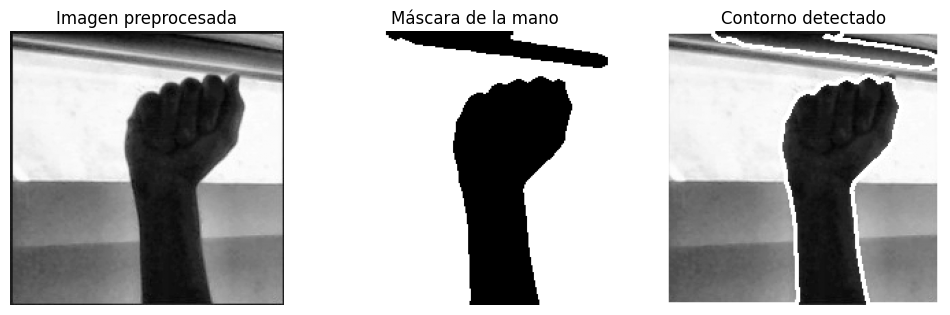

Hu Moments: [ 2.99090215  7.89050951 10.77742581 10.68207793 21.50738198 14.6867962
 21.63611366]
Dimensión HOG: (8100,)
Vector Zernike: [0.31830989 0.00089655 0.29436023 0.02156465 0.13231893 0.04486584
 0.14850142 0.02452468 0.1102358  0.21276567 0.16903634 0.05621345
 0.14542706 0.03192433 0.11304877 0.01269718 0.10558632 0.13386916
 0.04430625 0.01881142 0.05270212 0.04204733 0.12289453 0.03435122
 0.06071866]
Cantidad de keypoints ORB: 42


In [4]:
# Ruta a una imagen de ejemplo (cambia la ruta según tu dataset)
ruta_imagen = "ASL\\input\\asl_alphabet_test\\asl_alphabet_test\\A_test.jpg"
imagen = cv2.imread(ruta_imagen)
if imagen is None:
    raise Exception("No se pudo cargar la imagen. Revisa la ruta.")

# Preprocesar la imagen: CLAHE + corrección gamma + segmentación
imagen_corr, mascara, contorno_mano = preprocesar_imagen(imagen, gamma=1.2)

# Mostrar imagen preprocesada y máscara
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(imagen_corr, cmap='gray')
plt.title("Imagen preprocesada")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(mascara, cmap='gray')
plt.title("Máscara de la mano")
plt.axis("off")

# Dibujar el contorno en la imagen preprocesada
imagen_contorno = imagen_corr.copy()
if contorno_mano is not None:
    cv2.drawContours(imagen_contorno, [contorno_mano], -1, (255,0,0), 2)
plt.subplot(1,3,3)
plt.imshow(imagen_contorno, cmap='gray')
plt.title("Contorno detectado")
plt.axis("off")
plt.show()

# Calcular descriptores:
hu = calcular_hu_moments(mascara)
hog_features = calcular_hog(imagen_corr, contorno_mano)
zernike = calcular_zernike(mascara, grado=8)
kp_orb, orb_desc = calcular_orb(imagen_corr, mascara)

print("Hu Moments:", hu)
print("Dimensión HOG:", hog_features.shape)
print("Vector Zernike:", zernike)
print("Cantidad de keypoints ORB:", len(kp_orb))


In [5]:
# Directorio de imágenes de entrenamiento (ajusta la ruta según tu estructura)
database_path = 'ASL\\input\\asl_alphabet_train\\asl_alphabet_train'
pkl_path = "ASL\\output\\opencv_database_mejorado.pkl"
train_images_per_class = 10
test_images_per_class = 100

db_start_time = time.time()

if os.path.exists(pkl_path):
    db_descriptors = joblib.load(pkl_path)
    print("Cargado la base de datos desde", pkl_path)
else:
    db_descriptors = {'train': {}, 'test': {}}
    
    for label in os.listdir(database_path):
        label_path = os.path.join(database_path, label)
        if not os.path.isdir(label_path):
            continue
        
        db_descriptors['train'][label] = []
        db_descriptors['test'][label] = []
        
        img_files = os.listdir(label_path)
        random.shuffle(img_files)
        
        count = 0
        for img_file in img_files:
            if count >= train_images_per_class + test_images_per_class:
                break
            img_path = os.path.join(label_path, img_file)
            imagen = cv2.imread(img_path)
            if imagen is None:
                continue
            
            # Preprocesamiento
            imagen_corr, mascara, contorno_mano = preprocesar_imagen(imagen, gamma=1.2)
            if mascara is None or contorno_mano is None:
                continue
            
            # Calcular descriptores
            hu = calcular_hu_moments(mascara)
            hog_features = calcular_hog(imagen_corr, contorno_mano)
            zernike = calcular_zernike(mascara, grado=8)
            # Puedes combinar o elegir uno de ellos; aquí guardamos todos
            descriptor = {
                'hu': hu,
                'hog': hog_features.flatten(),
                'zernike': zernike
            }
            
            if count < train_images_per_class:
                db_descriptors['train'][label].append(descriptor)
            else:
                db_descriptors['test'][label].append(img_path)
            
            count += 1

    os.makedirs(os.path.dirname(pkl_path), exist_ok=True)
    joblib.dump(db_descriptors, pkl_path)
    print("Base de datos construida y guardada en", pkl_path)

db_end_time = time.time()
print("\nTiempo de creación de la base de datos: {:.2f} segundos".format(db_end_time - db_start_time))
print("Estadísticas del dataset:")
print(f"Imágenes de entrenamiento por clase: {train_images_per_class}")
print(f"Imágenes de test por clase: {test_images_per_class}")
print("Etiquetas disponibles:", list(db_descriptors['train'].keys()))


Cargado la base de datos desde ASL\output\opencv_database_mejorado.pkl

Tiempo de creación de la base de datos: 0.26 segundos
Estadísticas del dataset:
Imágenes de entrenamiento por clase: 10
Imágenes de test por clase: 100
Etiquetas disponibles: ['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [6]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def match_descriptor(query_descriptor, db_descriptor, weight_hu=0.5, weight_hog=0.3, weight_zernike=0.2):
    """
    Calcula una distancia combinada ponderada entre el descriptor de consulta y el descriptor de la base.
    Se utiliza la distancia Euclídea para cada parte.
    """
    hu_query = query_descriptor['hu']
    hog_query = query_descriptor['hog']
    zernike_query = query_descriptor['zernike']
    
    hu_db = db_descriptor['hu']
    hog_db = db_descriptor['hog']
    zernike_db = db_descriptor['zernike']
    
    dist_hu = np.linalg.norm(hu_query - hu_db)
    dist_hog = np.linalg.norm(hog_query - hog_db)
    dist_zernike = np.linalg.norm(zernike_query - zernike_db)
    
    return weight_hu * dist_hu + weight_hog * dist_hog + weight_zernike * dist_zernike

true_labels = []
predicted_labels = []
all_scores = []
processed_test_images = 0

test_start_time = time.time()

# Para cada clase y cada imagen de test, se extrae el descriptor en tiempo real y se compara
for label in db_descriptors['test'].keys():
    for test_img_path in db_descriptors['test'][label]:
        imagen = cv2.imread(test_img_path)
        if imagen is None:
            continue
        
        imagen_corr, mascara, contorno_mano = preprocesar_imagen(imagen, gamma=1.2)
        if mascara is None or contorno_mano is None:
            continue
        
        # Extraer descriptores de la imagen de test
        hu_query = calcular_hu_moments(mascara)
        hog_query = calcular_hog(imagen_corr, contorno_mano).flatten()
        zernike_query = calcular_zernike(mascara, grado=8)
        query_descriptor = {
            'hu': hu_query,
            'hog': hog_query,
            'zernike': zernike_query
        }
        
        scores = {}
        # Comparar con cada descriptor en el conjunto de entrenamiento
        for train_label, descriptor_list in db_descriptors['train'].items():
            distancias = []
            for db_descriptor in descriptor_list:
                score = match_descriptor(query_descriptor, db_descriptor)
                distancias.append(score)
            if distancias:
                scores[train_label] = np.min(distancias)
                
        if scores:
            recognized_label = min(scores, key=scores.get)
            true_labels.append(label)
            predicted_labels.append(recognized_label)
            all_scores.append(scores)
            processed_test_images += 1

test_end_time = time.time()
evaluation_time = test_end_time - test_start_time
fps = processed_test_images / evaluation_time if evaluation_time > 0 else 0

accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')

lb = LabelBinarizer()
y_true = lb.fit_transform(true_labels)
y_scores = np.zeros_like(y_true, dtype=np.float64)
for i, scores in enumerate(all_scores):
    for lab, score in scores.items():
        label_idx = lb.transform([lab])[0]
        y_scores[i] += label_idx * (1 - score)  # Convertir distancia a similaridad

roc_auc = roc_auc_score(y_true, y_scores, multi_class='ovr')

print("\nMétricas de Evaluación en el Conjunto de Test:")
print("Accuracy: {:.4f}".format(accuracy))
print("F1 Score: {:.4f}".format(f1))
print("ROC AUC: {:.4f}".format(roc_auc))
print("Imágenes de Test Procesadas:", processed_test_images)
print("Tiempo de Evaluación: {:.2f} segundos".format(evaluation_time))
print("FPS (Imágenes por Segundo): {:.2f}".format(fps))



Métricas de Evaluación en el Conjunto de Test:
Accuracy: 0.4893
F1 Score: 0.4908
ROC AUC: 0.7230
Imágenes de Test Procesadas: 2900
Tiempo de Evaluación: 340.37 segundos
FPS (Imágenes por Segundo): 8.52
